# Spectral intensity decomposition

This notebook demonstrates how to use the calculation of the eigenvectors and eigenvalues of the [Laplace-Beltrami-Operator](https://en.wikipedia.org/wiki/Laplace%E2%80%93Beltrami_operator) to be used as basis vectors for the expansion of measured values on the surface of a mesh.

This approach has first been demonstrated in [this paper](https://www.nature.com/articles/s43588-023-00512-4), pleas make sure to cite it if you use this code.

In [1]:
import numpy as np
import napari_shape_odyssey as nso
import matplotlib.pyplot as plt
import matplotlib as mpl
import napari

In [2]:
viewer = napari.Viewer(ndisplay=3)

Invalid schema for package 'napari-stl-exporter', please run 'npe2 validate napari-stl-exporter' to check for manifest errors.


## Sample data

Akin to how it is demonstrated in the paper, we use a simple sphere with generated polka dots of different number and size as sample data.

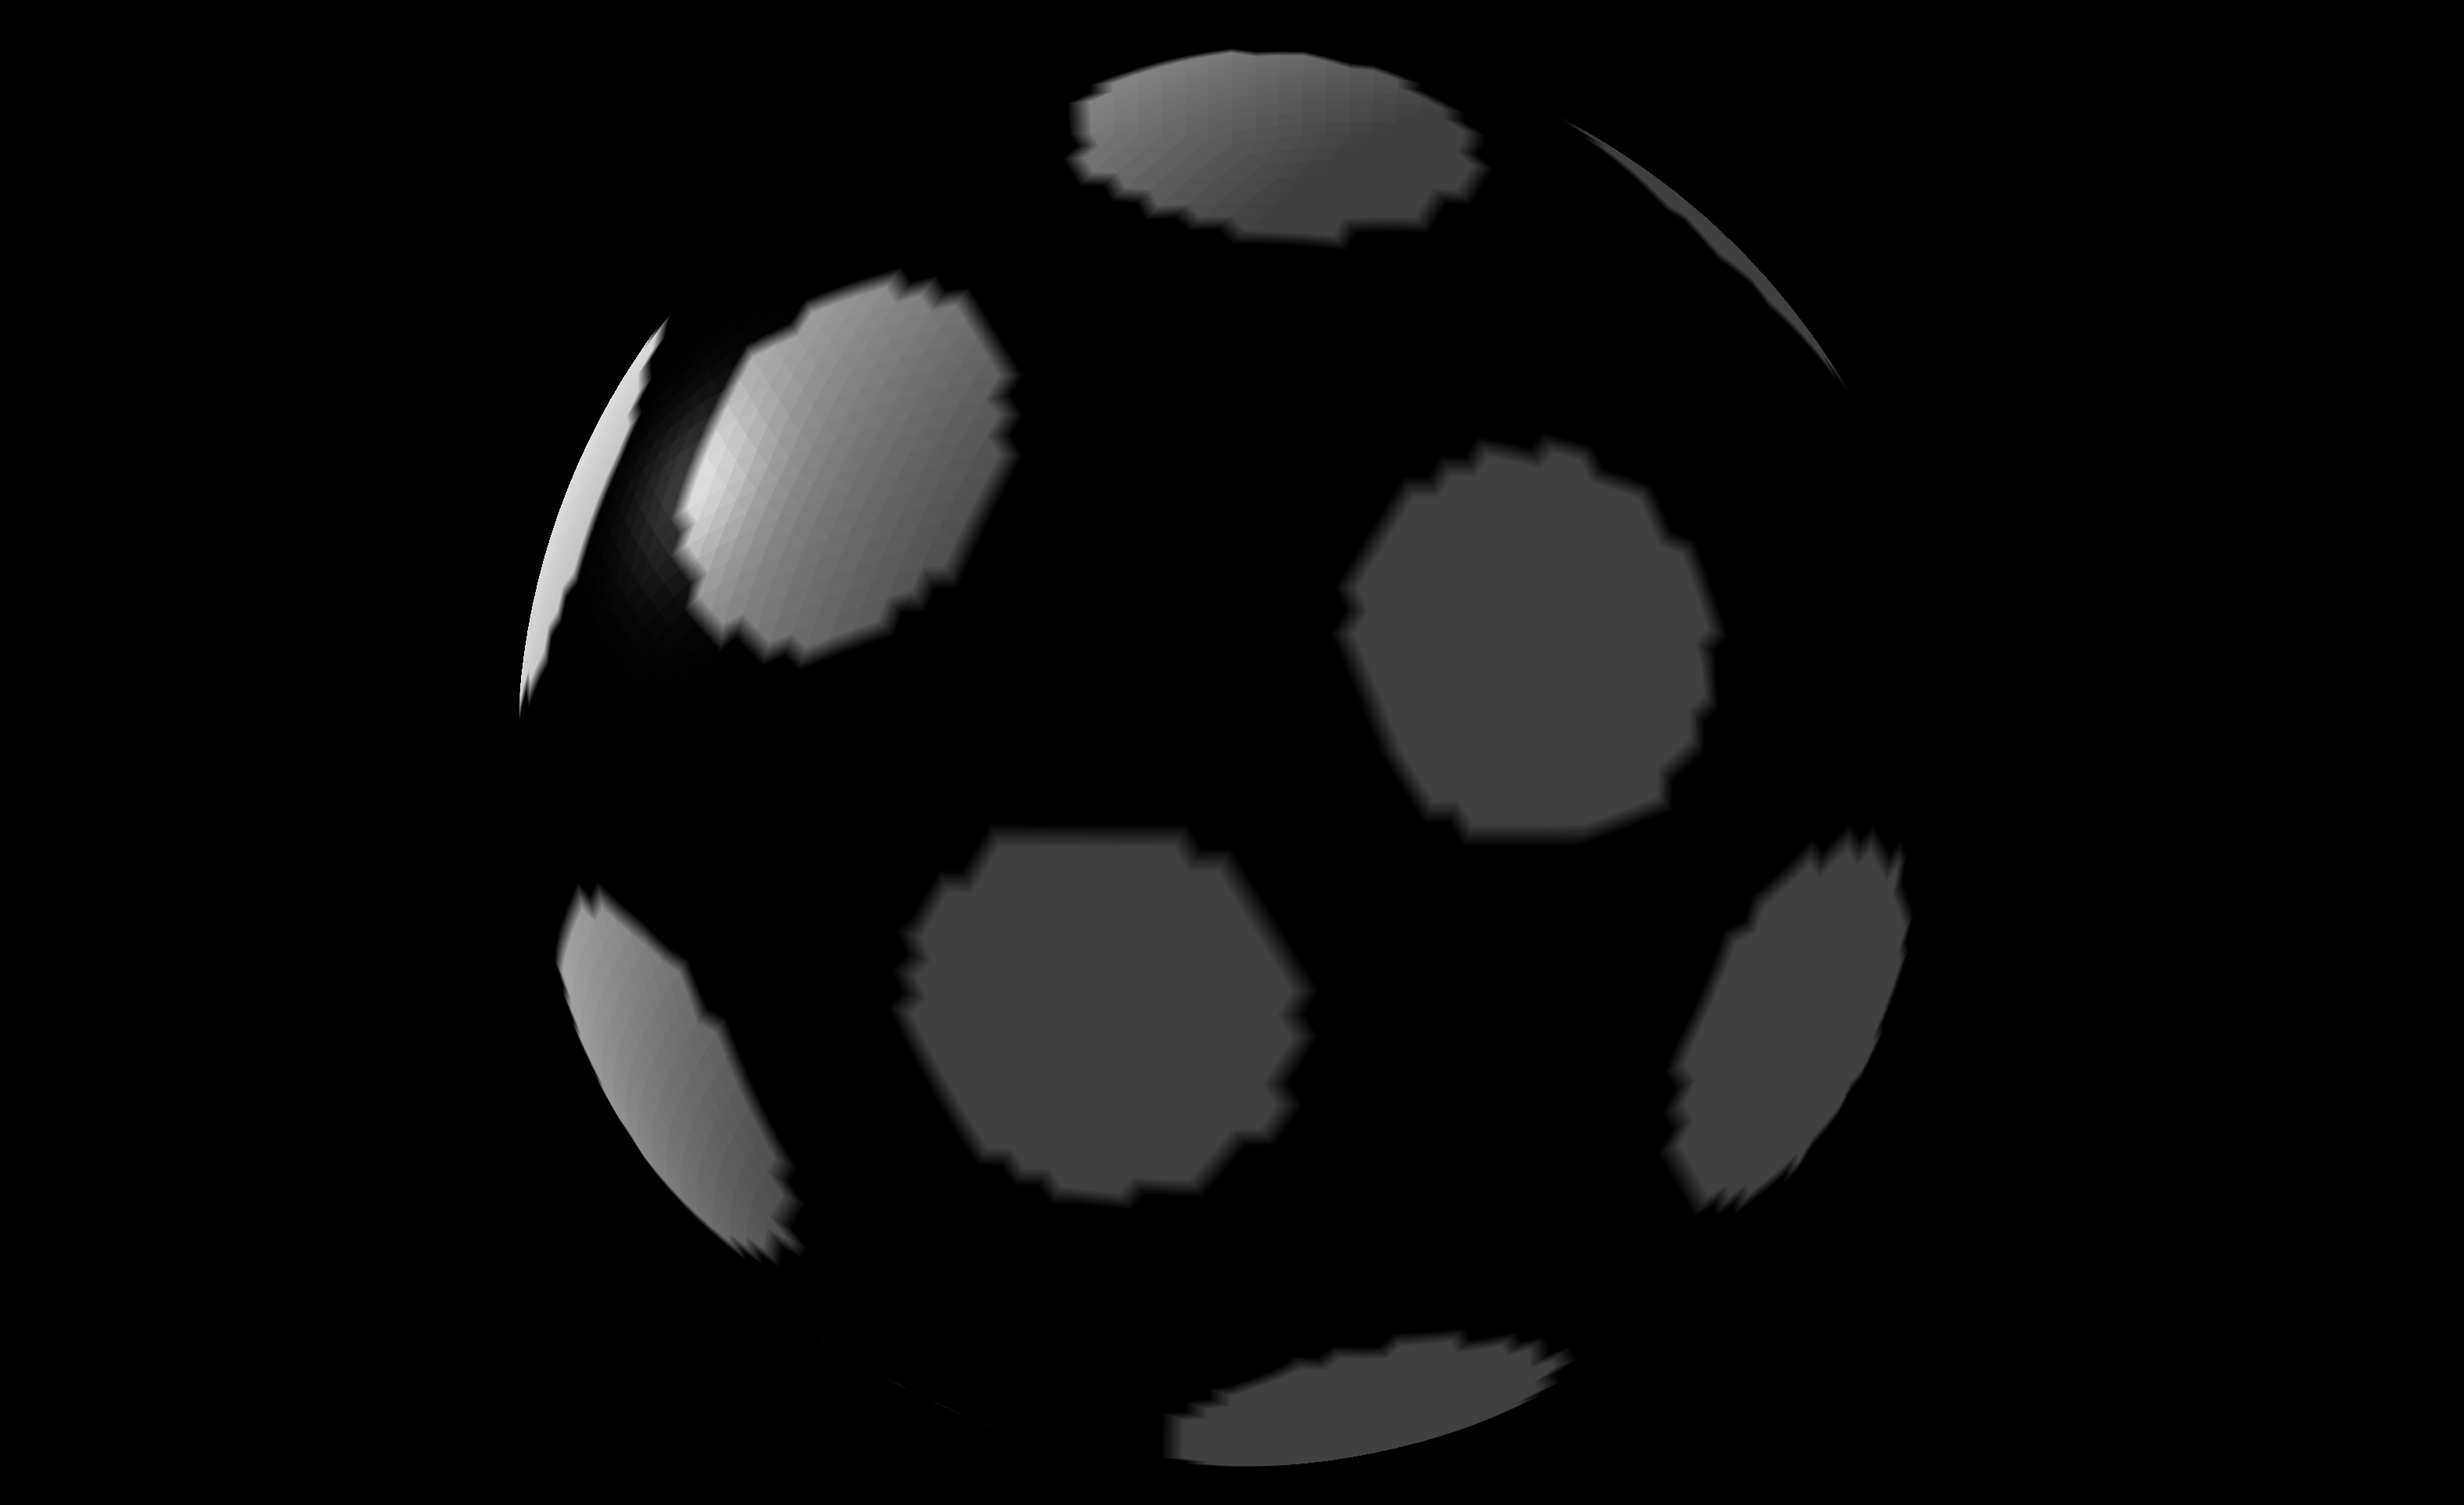

In [3]:
dots = nso.generate_polka_dot_surface(n_subdivisions=5, n_dots=16, coverage=0.3)
viewer.add_surface(dots)

napari.utils.nbscreenshot(viewer, canvas_only=True)

## Expand intensity in Laplace-Beltrami eigenvector basis

In [4]:
Expander = nso.spectral.LBOIntensityExpander(normalize=True, order=1000)
expanded_intensity = Expander.fit_expand(dots)

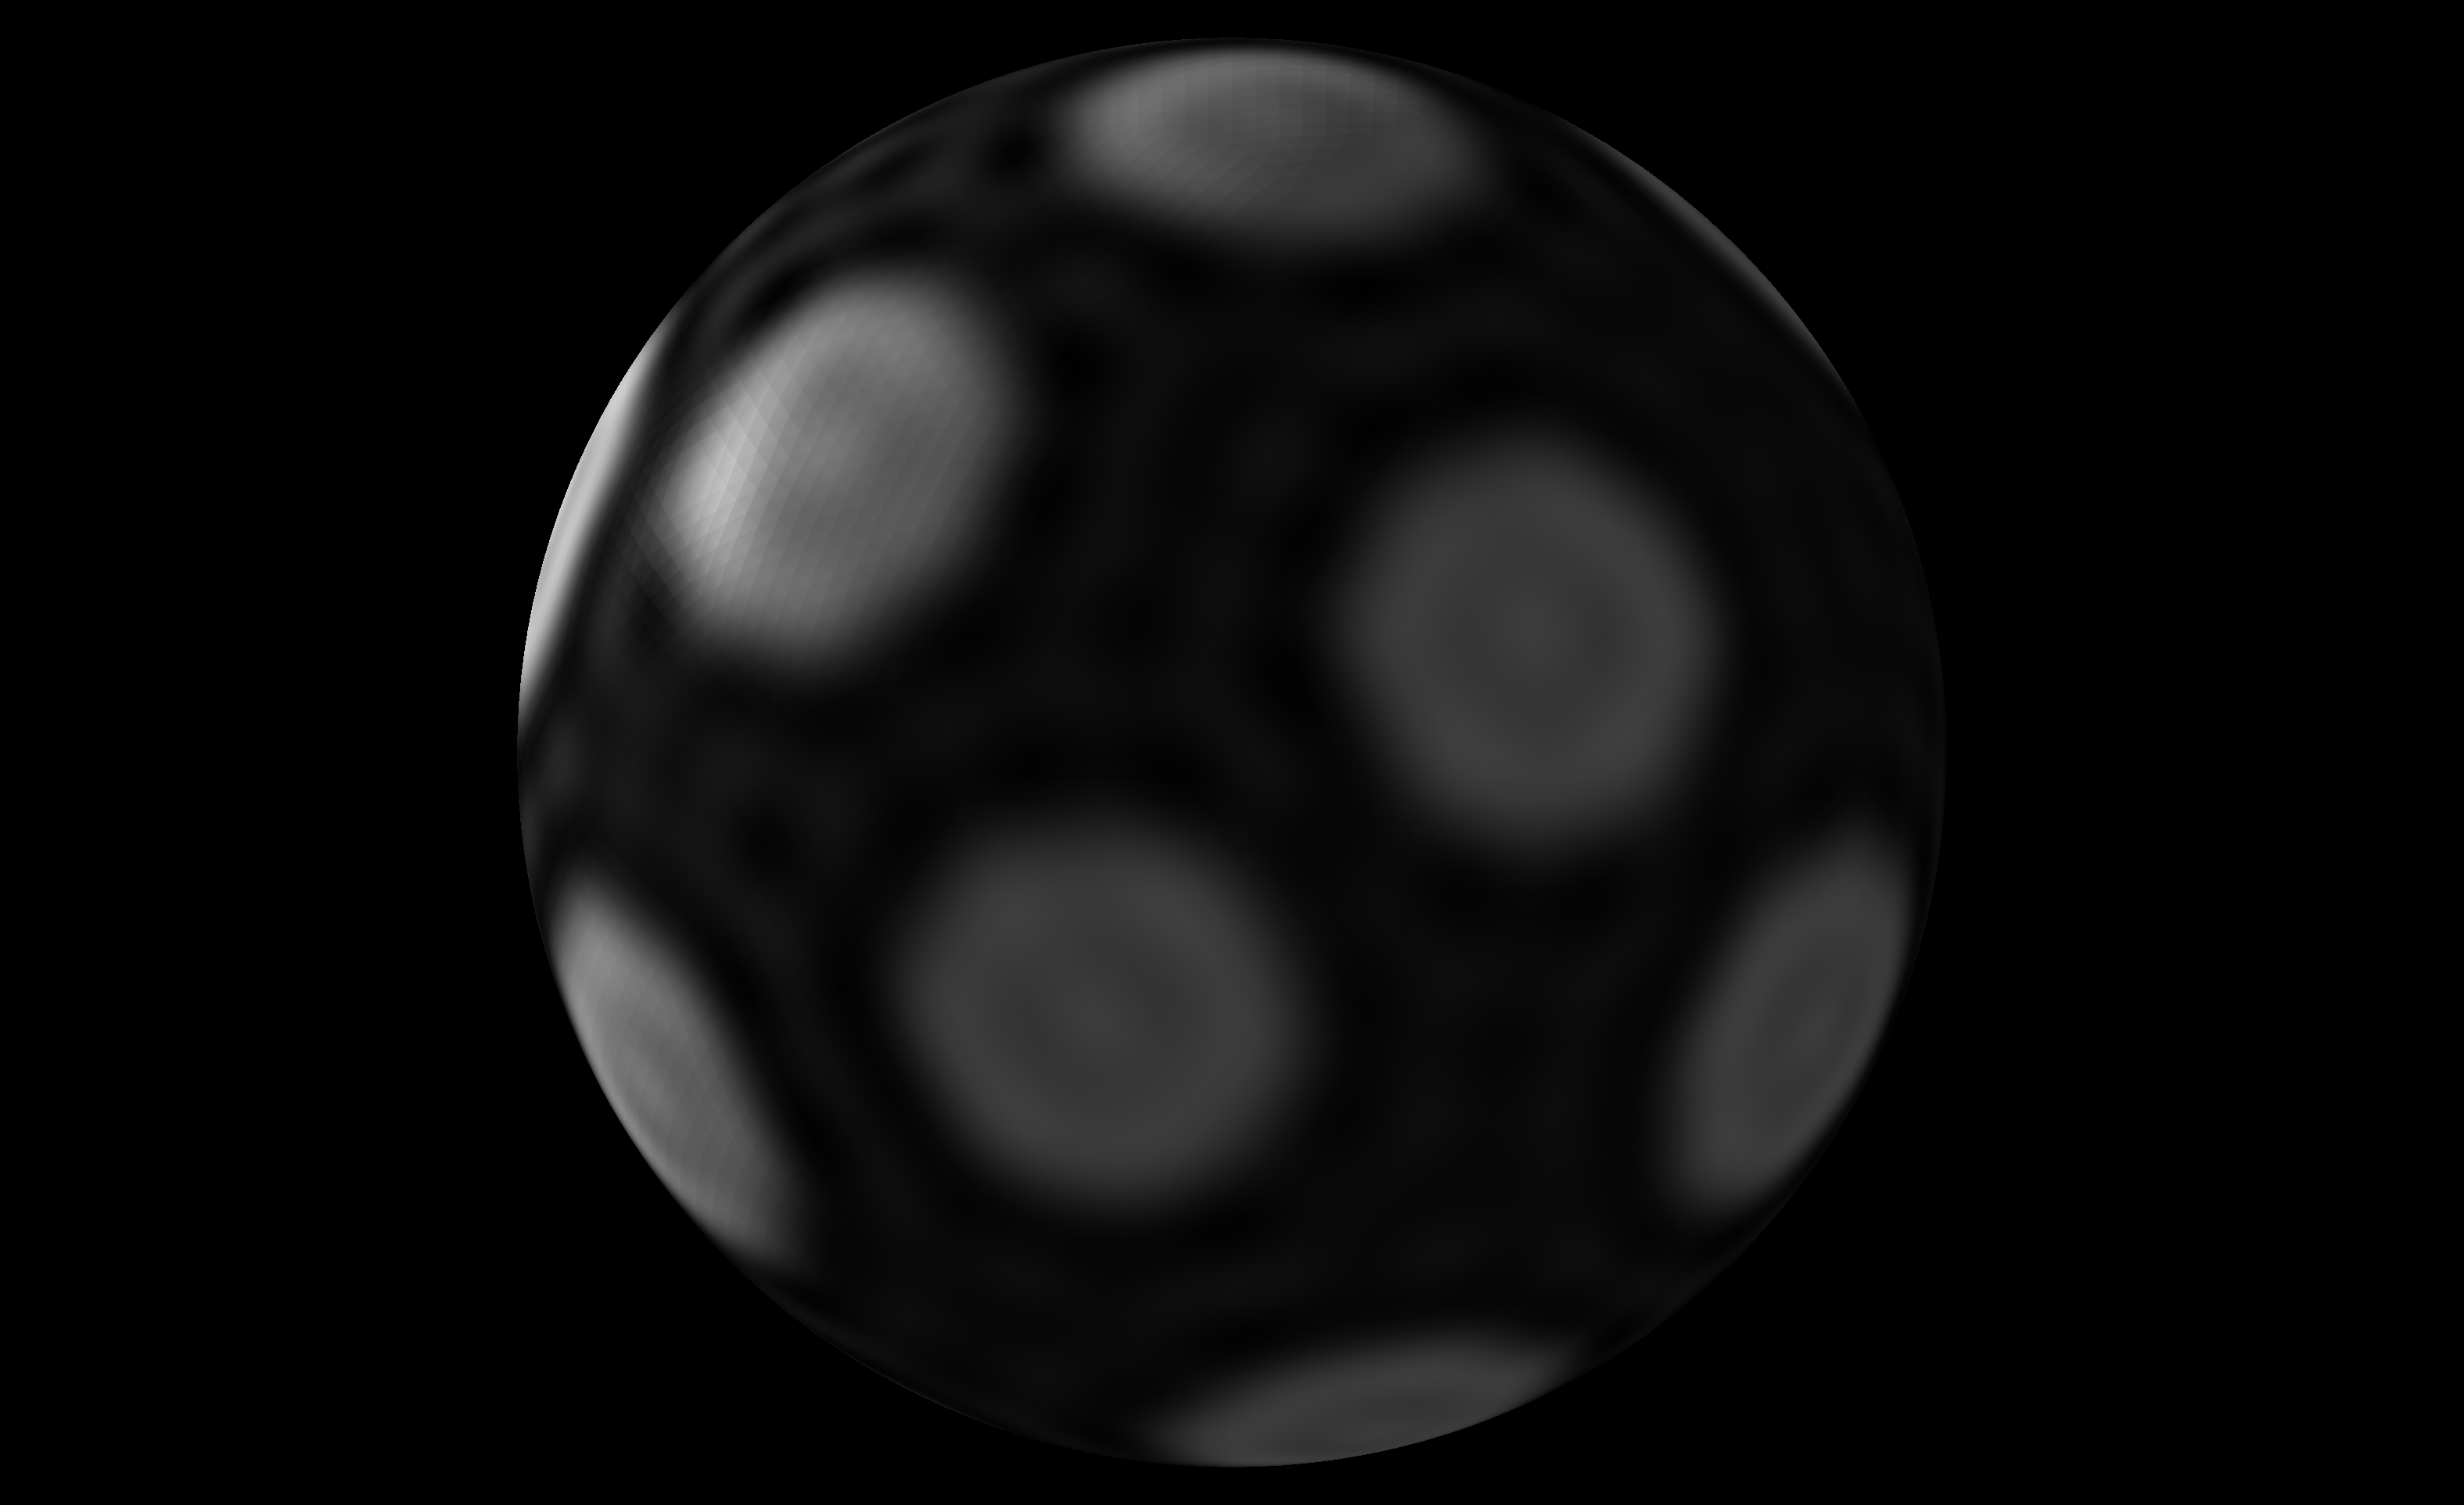

In [5]:
viewer.add_surface(expanded_intensity)
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Analyze contribution by coefficients

In order to analyze on what scale intensity is distributed on the surface of the object, we can do the expansion of the "measured" intensity up to a multiple orders (i.e., include coefficients up to a set point) and then measure the difference in expanded and measured intensity.

In [6]:
characteristics = Expander.characterize_contributions_per_level(normalize_eigenvalues=False)
characteristics.head(5)

,level,difference_mean,difference_std,energy
0,0.0,0.431563,0.171815,7.370496e-07
1,1.0,0.431550,0.171813,1.644113e-04
2,2.0,0.431106,0.172591,1.148784e-01
3,3.0,0.430522,0.173110,1.812391e-01
4,4.0,0.422511,0.180789,4.572635e+00


In [7]:
mpl.style.use('default')

Plot the mean and standard deviation of the difference between the original and reconstructed intensity

Text(0.5, 0, 'LBO level')

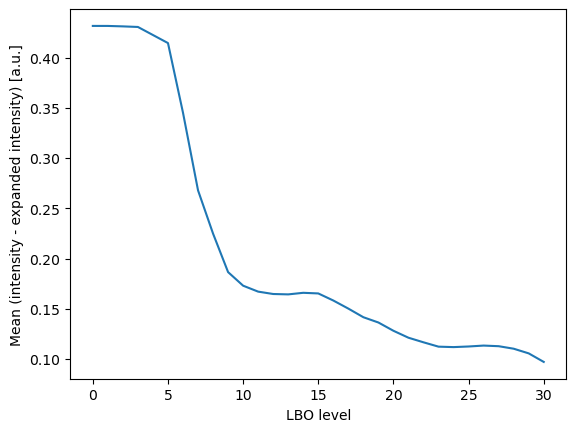

In [8]:
fig, ax = plt.subplots()
ax.plot(characteristics['level'], characteristics['difference_mean'], label='mean')
ax.set_ylabel('Mean (intensity - expanded intensity) [a.u.]')
ax.set_xlabel('LBO level')

We now plot the energy per level of the expansion.

Text(0.5, 0, 'LBO level [#]')

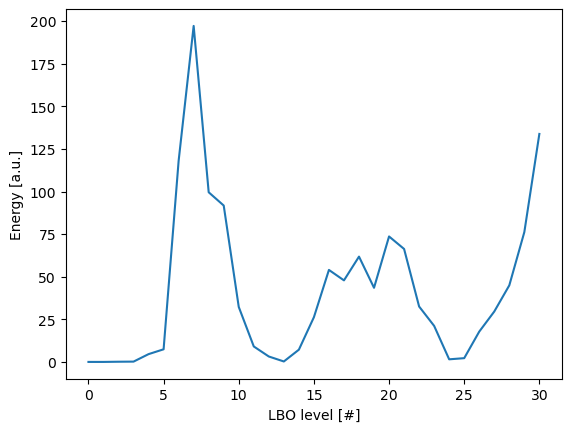

In [9]:
fig, ax = plt.subplots()
ax.plot(characteristics['level'], characteristics['energy'], label='energy')

ax.set_ylabel('Energy [a.u.]')
ax.set_xlabel('LBO level [#]')

## Comparison of different spectra

To demonstrate the value of this approach, we compare the spectra of different meshes. For this, we genreate polka dot meshes with dots at different densities, whereas we leave the area of the covered surface constant.

In [19]:
n_dots = [4, 8, 16]

surfaces = [
    nso.generate_polka_dot_surface(n_subdivisions=5, n_dots=n, coverage=0.3) for n in n_dots
]

characteristics = []
screenshots = []
for idx, n_dot in enumerate(n_dots):
    Expander.fit(surfaces[idx])
    characteristics.append(Expander.characterize_contributions_per_level(normalize_eigenvalues=False))

    viewer.layers.clear()
    viewer.add_surface((surfaces[idx][0], surfaces[idx][1], Expander.expand()))
    screenshots.append(viewer.screenshot(canvas_only=True))

Plotting the differences in intensity between the input intensitires and the expanded intensities, we can see that, for all polka dot patterns, including more levels in the calculation of the expansion coefficients leads to a better reconstruction of the original intensity.

Secondly, we can observe that the energy per level (right-hand side) differs from surface to surface, which reflects the different patterns of the polka dots. This means that the energy per level can be used to distinguish between different patterns on the surface of the object.

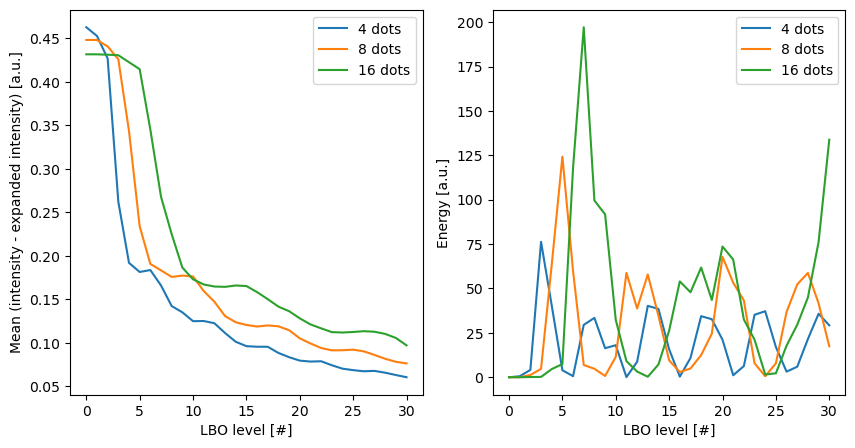

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

for idx, n_dot in enumerate(n_dots):
    axes[0].plot(characteristics[idx]['level'], characteristics[idx]['difference_mean'], label=f'{n_dot} dots')
    axes[1].plot(characteristics[idx]['level'], characteristics[idx]['energy'], label=f'{n_dot} dots')

axes[0].set_ylabel('Mean (intensity - expanded intensity) [a.u.]')
axes[0].set_xlabel('LBO level [#]')
axes[0].legend()

axes[1].set_ylabel('Energy [a.u.]')
axes[1].set_xlabel('LBO level [#]')
axes[1].legend()

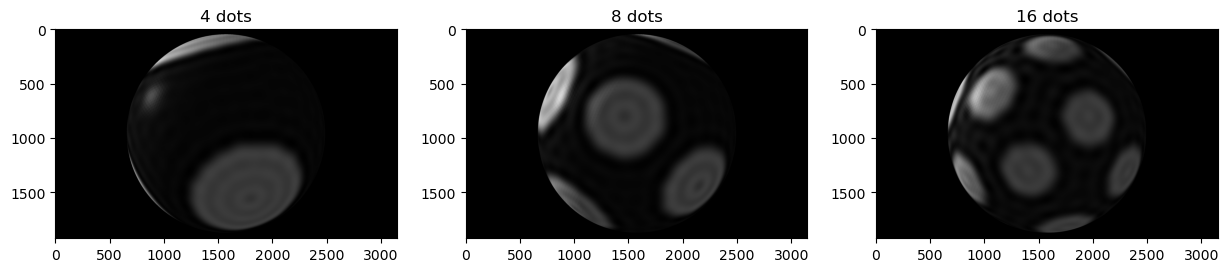

In [23]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

for idx, n_dot in enumerate(n_dots):
    axes[idx].imshow(screenshots[idx])
    axes[idx].set_title(f'{n_dot} dots')